In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, ConvLSTM2D, Conv3D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

# Data Preprocessing

In [14]:
from data_preprocessing import preprocess_images

img_folder = 'data/data1-(8.7μm)'

img_tensor = preprocess_images(img_folder)

print(img_tensor)

[[[[0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]
   ...
   [0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]]

  [[0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]
   ...
   [0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]]

  [[0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]
   ...
   [0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]
   [0.         0.         0.         1.        ]]

  ...

  [[0.50980392 0.50980392 0.50980392 1.        ]
   [0.5372549  0.5372549  0.5372549

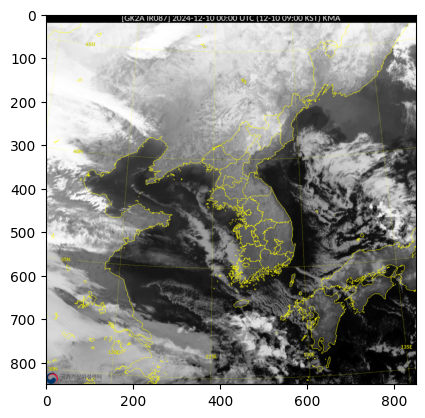

In [15]:
plt.imshow(img_tensor[0])

# Modeling

In [3]:
# 자 모델 구축 들갑니다~
model = Sequential()
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     input_shape=(None,850,850,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(Conv3D(filters=1, 
                 kernel_size=(3,3,3), 
                 activation="sigmoid",
                 padding="same"))
model.compile(loss='binary_crossentropy',optimizer='adadelta', metrics = ['accuracy'])
callbacks_val_acc = [EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True),
                     ModelCheckpoint("ClimateAI.keras", monitor='val_accuracy', save_best_only=True)]
callbacks_val_loss = [EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True),
                      ModelCheckpoint("ClimateAI.keras", monitor='val_loss', save_best_only=True)]
callbacks = [callbacks_val_acc, callbacks_val_loss]

model.summary()

/Volumes/looparam/#1 Coding/#10 Python/AcademicFestival/AF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, None, 850, 850, │        62,080 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 850, 850, │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, None, 850, 850, │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 850, 850, │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, None, 850, 850, │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 850, 850, │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, None, 850, 850, │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, None, 850, 850, │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, None, 850, 850, │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, None, 850, 850, │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, None, 850, 850, │         1,081 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,401 (2.00 MB)

 Trainable params: 525,001 (2.00 MB)

 Non-trainable params: 400 (1.56 KB)

# Train

In [ ]:
model.fit()